In [1]:
import os, sys
os.environ['R_HOME'] = sys.exec_prefix + '/lib/R/'
import numpy as np
import scanpy as sc
import scFates as scf
import matplotlib.pyplot as plt

In [2]:
geo = 'GSE229103'
pth = os.path.join('..', '..')
pth_data = os.path.join(pth, 'data')
pth_in = os.path.join(pth_data, 'processed')
pth_out = os.path.join(pth_data, 'trajectories')
pth_feat = os.path.join(pth_data, 'features')
pth_fig = os.path.join(pth, 'figures', 'preprocessing')

In [ ]:
adata = sc.read_h5ad(os.path.join(pth_in, f'{geo}.h5ad'))
adata

AnnData object with n_obs × n_vars = 11255 × 20088
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'leiden', 'T+ Sox2+', 'celltype'
    var: 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'm', 'v', 'n_obs', 'res', 'lp', 'lpa', 'qv', 'highly_variable'
    uns: 'T+ Sox2+_colors', 'celltype_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

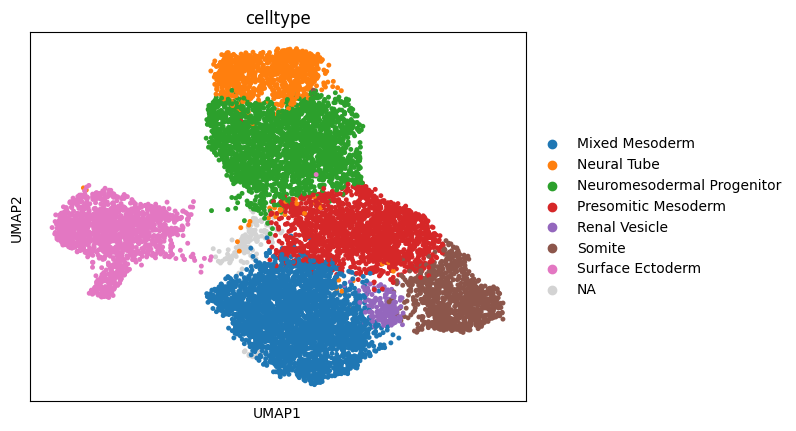

In [4]:
sc.pl.umap(adata, color = 'celltype', size = 50)

In [ ]:
keep = ['Neuromesodermal Progenitor', 'Presomitic Mesoderm']
adata = adata[adata.obs.celltype.isin(keep)].copy()
adata

View of AnnData object with n_obs × n_vars = 4260 × 20088
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'leiden', 'T+ Sox2+', 'celltype'
    var: 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'm', 'v', 'n_obs', 'res', 'lp', 'lpa', 'qv', 'highly_variable'
    uns: 'T+ Sox2+_colors', 'celltype_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

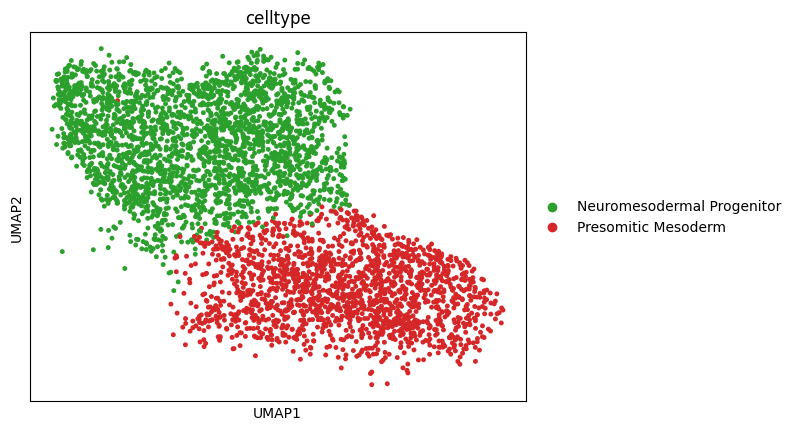

In [7]:
sc.pl.umap(adata, color = 'celltype', size = 50)

inferring a principal curve --> parameters used 
    15 principal points, mu = 100, lambda = 0.01


/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/scFates/tools/graph_fitting.py:565: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["graph"] = graph


    finished (0:00:02) --> added 
    .uns['epg'] dictionnary containing inferred elastic curve generated from elpigraph.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'], coordinates of principal points in representation space.


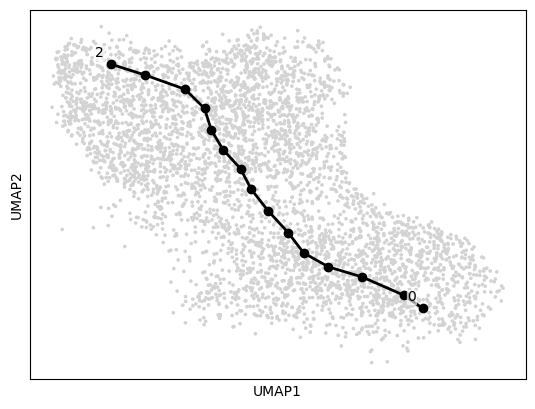

In [8]:
scf.tl.curve(adata, Nodes = 15, epg_lambda = .01, epg_mu = 100, use_rep = 'X_umap', plot = True, basis = 'umap')

In [9]:
scf.tl.root(adata, 2)

node 2 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.


In [10]:
scf.tl.pseudotime(adata)

projecting cells onto the principal graph
    finished (0:00:00) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


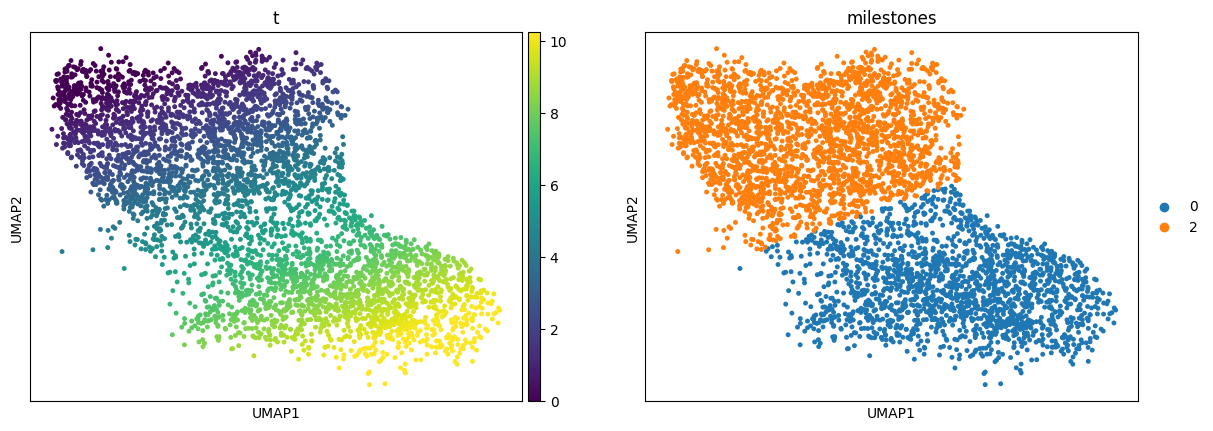

In [11]:
sc.pl.umap(adata, color = ['t', 'milestones'], size = 50)

/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


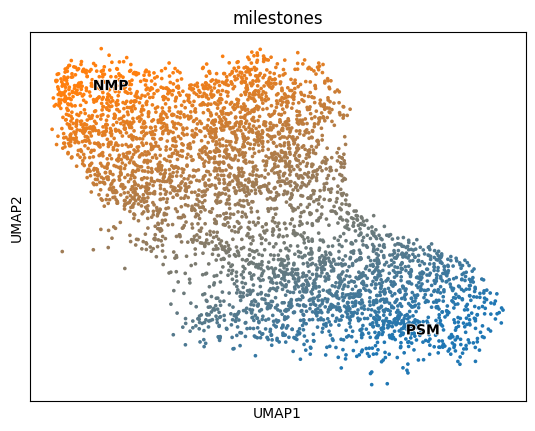

In [ ]:
scf.tl.rename_milestones(adata, new = {'0' : 'PSM', '2' : 'NMP'})
scf.pl.milestones(adata, basis = 'umap', annotate = True)

In [13]:
scf.tl.test_association(adata, n_jobs = 8)

test features for association with the trajectory
    single mapping : 100%|██████████| 20088/20088 [13:46<00:00, 24.31it/s]
    found 35 significant features (0:13:47) --> added
    .var['p_val'] values from statistical test.
    .var['fdr'] corrected values from multiple testing.
    .var['st'] proportion of mapping in which feature is significant.
    .var['A'] amplitue of change of tested feature.
    .var['signi'] feature is significantly changing along pseudotime.
    .uns['stat_assoc_list'] list of fitted features on the graph for all mappings.


In [14]:
scf.tl.test_association(adata, reapply_filters = True, A_cut = .5)

reapplied filters, 162 significant features


In [15]:
scf.tl.fit(adata, n_jobs = 8)

fit features associated with the trajectory
    single mapping : 100%|██████████| 162/162 [00:12<00:00, 13.03it/s]
    finished (adata subsetted to keep only fitted features!) (0:00:13) --> added
    .layers['fitted'], fitted features on the trajectory for all mappings.
    .raw, unfiltered data.


In [ ]:
del adata.uns['epg']
adata.write(os.path.join(pth_out, f'{geo}.h5ad'))
np.savetxt(os.path.join(pth_feat, f'{geo}.txt'), adata.var_names, fmt = '%s')

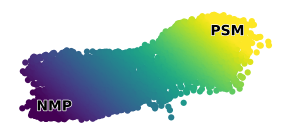

In [17]:
s = 80
fig, ax = plt.subplots(1, 1, figsize = (3.5, 1.5))
sc.pl.umap(adata, dimensions = [1, 0], color = 't',
           size = s, colorbar_loc = None,
           frameon = False, show = False, ax = ax)
sc.pl.umap(adata, dimensions = [1, 0], color = 'milestones',
           size = s, alpha = 0, legend_loc = 'on data',
           legend_fontoutline = 1, show = False, ax = ax)
ax.invert_xaxis(); ax.set_title('')

pos_dict = {'NMP' : (1.5, -1.75),
            'PSM' : (-1.33, 1.75)}
for label in ax.texts:
    _label_ = label.get_text()
    x, y = label.get_position()
    if _label_ in pos_dict:
        dx, dy = pos_dict[_label_]
        label.set_position([x + dx, y + dy])

fn = os.path.join(pth_fig, 'trajectories', f'{geo}.pdf')
plt.savefig(fn, bbox_inches = 'tight')

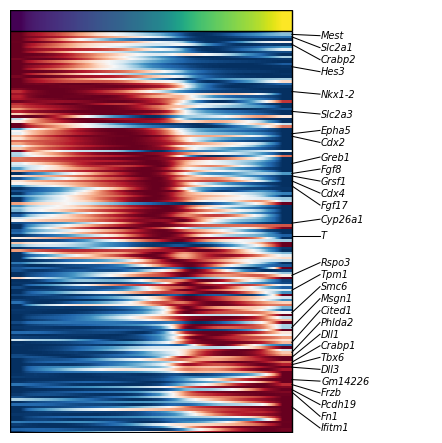

In [15]:
ax = scf.pl.trends(adata, features = adata.var_names,
                   ordering = 'quantile', n_features = 30,
                   offset_names = .1, fontsize = 7,
                   style = 'italic', plot_emb = False,
                   figsize = (6, 5.5), show = False)
fn = os.path.join(pth_fig, 'features', f'{geo}.pdf')
plt.savefig(fn, bbox_inches = 'tight')